# Tópicos Avanzados de Desarrollo Web - Sistemas de recomendación

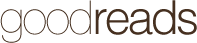

En este ejemplo trabajaremos a partir de un dataset de libros de la página [Goodreads](http://www.goodreads.com), **que ha sido previamente limpiado y adaptado**, para preparar algunos modelos de recomendación.

## Importando librerías y cargando los datos

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import warnings
warnings.filterwarnings('ignore')

Comenzamos por cargar en un Pandas DataFrame el dataset, que ya ha sido preparado y puesto a disposición en formato CSV en GitHub.

In [ ]:
books = pd.read_csv("https://raw.githubusercontent.com/hfmartinez85/datasets/main/tadw/books-clean.csv")

Exploremos el dataset:

In [ ]:
books

,book_id,isbn,title,original_title,authors,original_publication_year,average_rating,ratings_count,image_url,small_image_url,genres
0,2767052,439023483,"The Hunger Games (The Hunger Games, #1)",The Hunger Games,Suzanne Collins,2008,4.34,4780653,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"fiction, fantasy, romance, thriller, suspense,..."
1,3,439554934,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",1997,4.44,4602479,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"fantasy, fiction, classics, paranormal, myster..."
2,41865,316015849,"Twilight (Twilight, #1)",Twilight,Stephenie Meyer,2005,3.57,3866839,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"fantasy, fiction, paranormal, contemporary, ho..."
3,2657,61120081,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,1960,4.25,3198671,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,"classics, fiction, history, crime, contemporar..."
4,4671,743273567,The Great Gatsby,The Great Gatsby,F. Scott Fitzgerald,1925,3.89,2683664,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,"classics, fiction, romance"
...,...,...,...,...,...,...,...,...,...,...,...
9995,7130616,441019455,"Bayou Moon (The Edge, #2)",Bayou Moon,Ilona Andrews,2010,4.09,17204,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...,"fantasy, romance, paranormal, fiction, contemp..."
9996,208324,067973371X,"Means of Ascent (The Years of Lyndon Johnson, #2)",Means of Ascent,Robert A. Caro,1990,4.25,12582,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,"biography, history, nonfiction, classics"
9997,77431,039330762X,The Mauritius Command,The Mauritius Command,Patrick O'Brian,1977,4.35,9421,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...,"fiction, history, classics"
9998,8565083,61711527,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...,Peggy Orenstein,2011,3.65,11279,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...,"nonfiction, psychology, memoir, contemporary, ..."


## Recomendador simple

El **Recomendador Simple** ofrece recomendaciones generalizadas a cada usuario basadas en la popularidad del libro y (a veces) del género. La idea básica detrás de este recomendador es que los libros que son más populares y más aclamados por la crítica tendrán una mayor probabilidad de ser del agrado de la audiencia promedio. **Este modelo no da recomendaciones personalizadas en base al usuario**.

La implementación de este modelo es, en esencia, trivial. Todo lo que tenemos que hacer es clasificar nuestros libros según las calificaciones y la popularidad y mostrar los mejores libros de nuestra lista. Como paso adicional, podemos pasar un parámetro de género para obtener los mejores libros de un género en particular.

Sin embargo, nos apoyaremos en una **fórmula que diluya el sesgo** que pueda haber en libros con pocas calificaciones.

Usaremos la fórmula del rating ponderado de IMDB:

> Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

Donde:
* *v* es el número de ratings para el libro
* *m* es el mínimo número deseable de ratings para ser considerado
* *R* es el rating promedio del libro
* *C* es el rating promedio en todo el dataset

¿Qué tiene en cuenta esta fórmula?

1.   **Votos significativos**: La fórmula ajusta la calificación promedio (R) basándose en el número de votos (v). Cuanto mayor sea v, más peso tiene R en el resultado.
2.   **Calificación general**: En ítems con menos votos, la fórmula aplica una ponderación hacia C, la calificación promedio general, ayudando a evitar que calificaciones extremas dominen el ranking.
3.   **Balanceo**: Si un ítem tiene muchos votos (es decir, v es alto), su promedio será menos afectado por C. En cambio, si tiene pocos votos, C tiene mayor peso en la calificación final.

El siguiente paso es determinar un valor apropiado para *m*, las clasificaciones mínimas requeridas para tener en cuenta al libro. Probaremos con el **percentil 95**, es decir, el número que sirve de límite inferior al 5% de libros con mayor cantidad de calificaciones.

In [ ]:
print("Percentil 95 =", round(books['ratings_count'].quantile(0.95)))

Percentil 95 = 170455


In [ ]:
v = books['ratings_count']
m = books['ratings_count'].quantile(0.95)
R = books['average_rating']
C = books['average_rating'].mean()
W = (R*v + C*m) / (v + m)

In [ ]:
books['weighted_rating'] = W

In [ ]:
qualified = books.sort_values('weighted_rating', ascending=False).head(250)

Exploremos los 15 mejores libros:

In [ ]:
qualified[['title', 'authors', 'average_rating', 'ratings_count', 'weighted_rating', 'genres']].head(15)

,title,authors,average_rating,ratings_count,weighted_rating,genres
24,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,1746574,4.555956,"fantasy, fiction, classics, paranormal, myster..."
26,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54,1678823,4.490428,"fantasy, fiction, classics, paranormal, myster..."
17,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",4.53,1832823,4.485090,"fantasy, fiction, classics, paranormal, myster..."
23,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",4.53,1753043,4.483227,"fantasy, fiction, classics, paranormal, myster..."
1,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479,4.424365,"fantasy, fiction, classics, paranormal, myster..."
20,Harry Potter and the Order of the Phoenix (Har...,"J.K. Rowling, Mary GrandPré",4.46,1735368,4.419054,"fantasy, fiction, paranormal, mystery, romance"
30,The Help,Kathryn Stockett,4.45,1531753,4.405158,"fiction, contemporary, classics, history"
38,"A Game of Thrones (A Song of Ice and Fire, #1)",George R.R. Martin,4.45,1319204,4.398759,"fiction, fantasy, romance, classics, contemporary"
134,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,4.54,469022,4.396645,"fantasy, fiction, contemporary, romance"
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74,190050,4.391147,"fiction, fantasy, classics, paranormal, romanc..."


Cómo podemos ver, hay libros con mejores promedios de calificación que los que encabezan la lista, pero que por tener menor cantidad de *ratings* son retrasados en la lista.

Tambien podemos apreciar que los libros de Harry Potter de J.K. Rowling se encuentran en la parte superior de nuestra tabla, que son justamente los que mayor cantidad de calificaciones tienen.

Podemos sospechar que hay algún desbalance en la distribución de géneros de nuestro dataset. Podríamos realizar un análisis exploratorio para entender mejor esta característica:

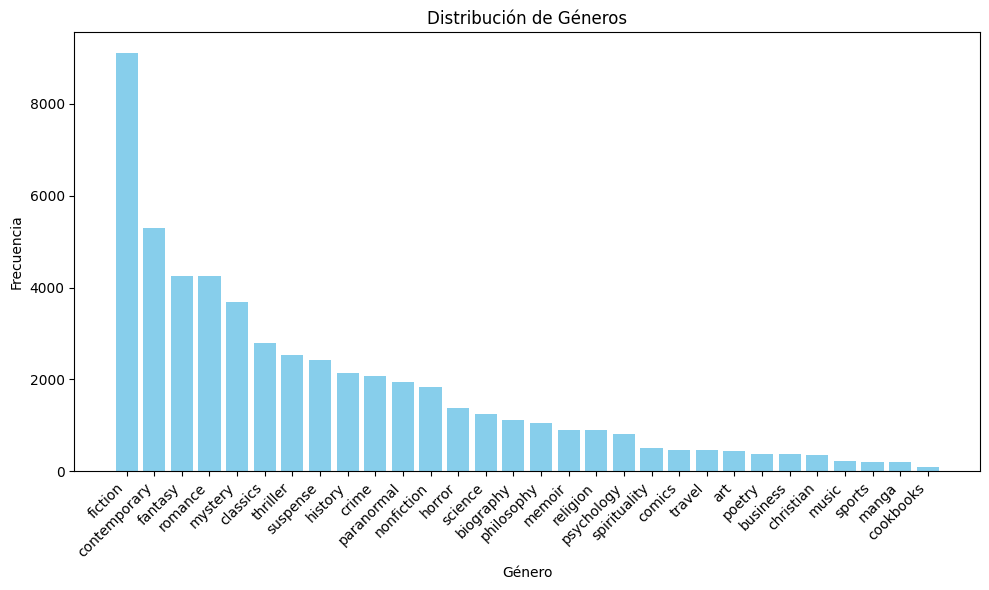

In [ ]:
# En primer lugar, separamos los géneros en listas
genres_list = books['genres'].str.split(', ')

# Reemplazamos valores nulos en genres_list con listas vacías
genres_list = genres_list.apply(lambda x: x if isinstance(x, list) else [])

# Creamos una lista única de todos los géneros
all_genres = sum(genres_list, [])

# Contamos la frecuencia de cada género
genre_counts = pd.DataFrame(Counter(all_genres).items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

# Visualizamos los resultados en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(genre_counts['genre'], genre_counts['count'], color='skyblue')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.title('Distribución de Géneros')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ajuste para evitar que se superpongan las etiquetas
plt.show()

Veamos ahora la distribución con un gráfico de torta:

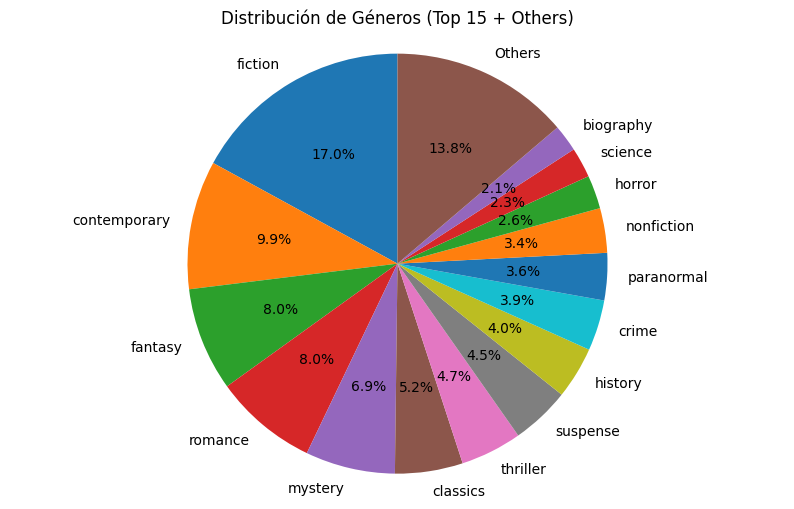

In [ ]:
# Filtramos los 15 géneros más frecuentes
top_genres = genre_counts.head(15)

# Sumamos el resto de los géneros en una única opción ("Others")
others_count = genre_counts['count'][15:].sum()

# Creamos un nuevo DataFrame para "Others"
others_df = pd.DataFrame({'genre': ['Others'], 'count': [others_count]})

# Concatenamos los dos DataFrames
final_genres = pd.concat([top_genres, others_df], ignore_index=True)

# Visualizamos el resultado en un gráfico de torta
plt.figure(figsize=(10, 6))
plt.pie(final_genres['count'], labels=final_genres['genre'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Para que el gráfico sea un círculo
plt.title('Distribución de Géneros (Top 15 + Others)')
plt.show()

En función de este desbalance que se puede observar, tal vez sea útil poder mejorar el recomendador para que opere dentro de un mismo género.

Construyamos entonces una función que permita crear rankings para géneros particulares. Para esto, relajaremos las condiciones predeterminadas al percentil 85 en lugar del 95.

### Mejores libros por género

In [ ]:
print("Percentil 85 =", round(books['ratings_count'].quantile(0.85)))

Percentil 85 = 65901


In [ ]:
def build_chart(genre, percentile=0.85):
    # Chequeamos que el libro pertenezca al género recibido, ignorando valores nulos
    qualified = books[books['genres'].notna() & books['genres'].str.lower().str.contains(genre.lower())]

    # Verificamos que haya libros calificados
    if qualified.empty:
        return "No hay libros calificados en este género."

    v = qualified['ratings_count']
    m = qualified['ratings_count'].quantile(percentile)
    R = qualified['average_rating']
    C = qualified['average_rating'].mean()
    qualified['weighted_rating'] = (R * v + C * m) / (v + m)

    qualified.sort_values('weighted_rating', ascending=False, inplace=True)
    return qualified

Probemos la función, armando el top de libros de biografías, que tiene una representación más acotada en el dataset:

In [ ]:
genre = 'Biography'
build_chart(genre).head(15)

,book_id,isbn,title,original_title,authors,original_publication_year,average_rating,ratings_count,image_url,small_image_url,genres,weighted_rating
143,8664353,1400064163,"Unbroken: A World War II Story of Survival, Re...","Unbroken: A World War II Story of Survival, Re...",Laura Hillenbrand,2010,4.40,487775,https://images.gr-assets.com/books/1327861115m...,https://images.gr-assets.com/books/1327861115s...,"history, biography, nonfiction, memoir, fictio...",4.360289
463,1923820,NaN,Holy Bible: King James Version,NaN,Anonymous,1611,4.43,159457,https://images.gr-assets.com/books/1313518530m...,https://images.gr-assets.com/books/1313518530s...,"religion, classics, christian, history, fictio...",4.321608
512,561909,553256696,The Hiding Place: The Triumphant True Story of...,The Hiding Place,"Corrie ten Boom, John Sherrill, Elizabeth Sher...",1971,4.42,171384,https://images.gr-assets.com/books/1320418824m...,https://images.gr-assets.com/books/1320418824s...,"biography, history, christian, nonfiction, cla...",4.319739
733,546018,440174643,Roots: The Saga of an American Family,Roots,Alex Haley,1976,4.42,118951,https://images.gr-assets.com/books/1329398936m...,https://images.gr-assets.com/books/1329398936s...,"fiction, classics, history, biography, nonfict...",4.289331
86,1617,374500010,Night (The Night Trilogy #1),Un di Velt Hot Geshvign,"Elie Wiesel, Marion Wiesel",1958,4.30,691231,https://images.gr-assets.com/books/1473495285m...,https://images.gr-assets.com/books/1473495285s...,"classics, history, nonfiction, fiction, memoir...",4.278369
489,15196,394541553,Maus I: A Survivor's Tale: My Father Bleeds Hi...,Maus: A Survivor's Tale : My Father Bleeds His...,Art Spiegelman,1985,4.35,184007,https://images.gr-assets.com/books/1327884972m...,https://images.gr-assets.com/books/1327884972s...,"comics, history, nonfiction, memoir, biography...",4.270924
2235,280111,310902711,Holy Bible: New International Version,Holy Bible: New International Version,Anonymous,1909,4.61,40430,https://images.gr-assets.com/books/1382581321m...,https://images.gr-assets.com/books/1382581321s...,"religion, christian, classics, nonfiction, his...",4.262004
1264,15197,679729771,Maus II: A Survivor's Tale: And Here My Troubl...,Maus II : And Here My Troubles Began,Art Spiegelman,1991,4.41,90147,https://images.gr-assets.com/books/1327887479m...,https://images.gr-assets.com/books/1327887479s...,"comics, history, memoir, nonfiction, biography...",4.256951
471,4069,080701429X,Man's Search for Meaning,…trotzdem Ja zum Leben sagen: Ein Psychologe e...,Viktor E. Frankl,1946,4.33,171281,https://images.gr-assets.com/books/1467136625m...,https://images.gr-assets.com/books/1467136625s...,"psychology, philosophy, nonfiction, history, m...",4.251245
982,25489625,812993543,Between the World and Me,Between the World and Me,Ta-Nehisi Coates,2015,4.40,74218,https://images.gr-assets.com/books/1451435027m...,https://images.gr-assets.com/books/1451435027s...,"nonfiction, memoir, biography, history, contem...",4.232135


Ahora estamos en condiciones de adaptar el recomendador para tener en cuenta un género en particular.

Sobre cómo dar un resultado final, en caso de que se espere un único registro, se pueden seguir varias estrategias. Por ejemplo, podemos entregar el mejor puntuado, o bien devolver uno al azar entre los primeros ***n*** mejores resultados del ranking.

## Recomendadores basados en contenido (content-based)

El recomendador que construimos en la sección anterior sufre de algunas limitaciones severas. Por un lado, da la misma recomendación a todos, independientemente del gusto personal del usuario.

Por ejemplo, consideremos a una persona que le gustó *The Fault in Our Stars* (Bajo la misma estrella) y *Twilight* (Crepúsculo). Una inferencia que podemos obtener es que a la persona le gustan los libros románticos. Pero incluso si accediera a la tabla de romances, no encontraría estas como las principales recomendaciones.

Para personalizar más nuestras recomendaciones, crearemos un motor que calcule la similitud entre ítems en función de ciertas métricas, y sugiera opciones que sean más parecidas a un libro en particular según los gustos de un usuario. Dado que usaremos metadatos (o contenido) de libros para construir este motor, esto también se conoce como **filtrado basado en contenido.**

![](https://miro.medium.com/max/828/1*1b-yMSGZ1HfxvHiJCiPV7Q.png)

**Como decisión de diseño, a partir de los atributos con los que contamos, construiremos este recomendador basado en el *título*, *autores* y *géneros* del libro.**

Estos son los pasos que seguiremos:

1. **Eliminar espacios y convertir a minúsculas** los nombres de los autores. De esta forma, nuestro motor no confundirá entre **Stephen Covey** y **Stephen King**.
2. Combinar en un mismo string **título**, **géneros** y **autores**.
3. Luego usaremos **count vectorizer** para crear una matriz de conteo.

Finalmente, calculamos las similitudes por coseno, y devolvemos los libros que son más similares.

In [ ]:
# Tranformación de autores
books['authors_clean'] = books['authors'].apply(lambda x: ', '.join(str.lower(i.replace(" ", "")) for i in x.split(', ')))

In [ ]:
# Veamos el resultado parcial
books['authors_clean'].head()

,authors_clean
0,suzannecollins
1,"j.k.rowling, marygrandpré"
2,stepheniemeyer
3,harperlee
4,f.scottfitzgerald


In [ ]:
# Combinamos en un mismo string los títulos, autores y géneros
books['soup'] = books.apply(lambda x: ' '.join([str(x['title']), str(x['authors_clean'] or ''), str(x['genres'] or '')]), axis=1)

In [ ]:
# Exploremos el resultado
books.soup.head()

,soup
0,"The Hunger Games (The Hunger Games, #1) suzann..."
1,Harry Potter and the Sorcerer's Stone (Harry P...
2,"Twilight (Twilight, #1) stepheniemeyer fantasy..."
3,"To Kill a Mockingbird harperlee classics, fict..."
4,"The Great Gatsby f.scottfitzgerald classics, f..."


In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
count_matrix = count.fit_transform(books['soup'])

Explicación del código anterior:

1. **`count = CountVectorizer(...)`**  
   Aquí estamos creando una instancia de `CountVectorizer`, una herramienta de la biblioteca `sklearn.feature_extraction.text`. `CountVectorizer` convierte texto en una **matriz de conteo de términos**, lo cual es útil para análisis de texto y clasificación. Veamos cada parámetro:

   - **`analyzer='word'`**: especifica que queremos analizar el texto por palabras, en lugar de por caracteres o subpalabras.
   - **`ngram_range=(1, 2)`**: indica que queremos considerar tanto palabras individuales (unigramas) como combinaciones de dos palabras consecutivas (bigramas).
   - **`min_df=0`**: establece que todas las palabras o bigramas, sin importar su frecuencia mínima, se incluyan en la matriz de conteo.
   - **`stop_words='english'`**: excluye las palabras comunes en inglés (como "the", "is", "and"), que suelen aportar poco al análisis.

2. **`count_matrix = count.fit_transform(books['soup'])`**  
   Aquí, `count.fit_transform()` aplica `CountVectorizer` a la columna `'soup'` del DataFrame `books`.

   - `fit_transform()` realiza dos tareas: primero, ajusta el modelo (`fit`), aprendiendo el vocabulario y los términos del texto, y luego convierte el texto en una **matriz esparsa** de conteo de términos (`transform`).
   
   Esta matriz `count_matrix` tiene cada fila representando un documento y cada columna representando una palabra o bigrama, con valores que indican la frecuencia de cada término en cada documento.

Así se vería un ejemplo de `count_matrix`:

|         | adventure | book | fiction | fantastic | mystery | mystery book | science | thrilling | thrilling mystery |
|---------|-----------|------|---------|-----------|---------|--------------|---------|-----------|--------------------|
| **0**   | 0         | 1    | 0       | 0         | 1       | 1            | 0       | 1         | 1                  |
| **1**   | 1         | 0    | 1       | 1         | 0       | 0            | 1       | 0         | 0                  |
| **2**   | 1         | 1    | 0       | 0         | 1       | 0            | 0       | 0         | 0                  |


### Similitud por coseno

Usaremos la similitud del coseno para medir la similitud entre dos libros.

Para entender el concepto, primero veamos un ejemplo simple, con dos vectores de dos dimensiones:

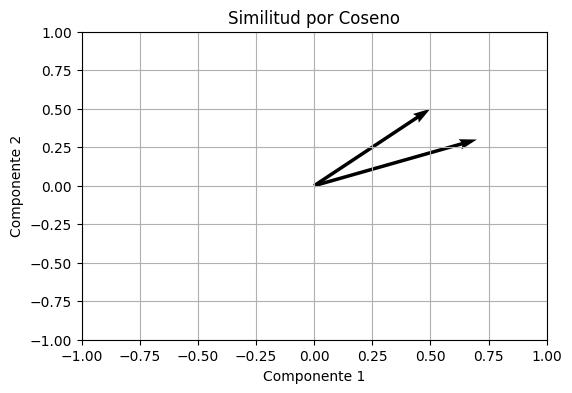

In [ ]:
# Creamos dos vectores de ejemplo
vector1 = np.array([0.7, 0.3])
vector2 = np.array([0.5, 0.5])

# Calculamos el producto punto
dot_product = np.dot(vector1, vector2)

# Calculamos las normas (magnitudes) de los vectores
norm_vector1 = np.linalg.norm(vector1)
norm_vector2 = np.linalg.norm(vector2)

# Calculamos la similitud por coseno
cosine_sim = dot_product / (norm_vector1 * norm_vector2)

# Veamos el resultado gráficamente
plt.figure(figsize=(6, 4))
plt.quiver([0, 0], [0, 0], [vector1[0], vector2[0]], [vector1[1], vector2[1]], angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Similitud por Coseno")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

La similitud por coseno es una medida de similaridad entre dos vectores no nulos en un espacio vectorial. Se calcula como el coseno del ángulo entre los dos vectores.

En el gráfico, los dos vectores se representan como flechas que parten del origen. El ángulo entre ellos es el formado por estas dos flechas.

**Interpretación del resultado:**

* **Similitud por coseno = 1:** Los vectores son idénticos y apuntan en la misma dirección.
* **Similitud por coseno = -1:** Los vectores son opuestos y apuntan en direcciones opuestas.
* **Similitud por coseno = 0:** Los vectores son ortogonales (perpendiculares).

**Cuanto más cercano esté el valor de la similitud por coseno a 1, más similares son los vectores.**

In [ ]:
print("En este ejemplo, la similitud por coseno es:", cosine_sim)

En este ejemplo, la similitud por coseno es: 0.9284766908852594


Volviendo ahora a nuestro caso de estudio con libros, calcularemos la similitud de coseno de la matriz `count_matrix` consigo misma, lo que significa que se está calculando la similitud entre todos los pares vectores **multidimensionales** de la matriz, que representan a cada uno de los libros.

El cálculo se apoya en una operación algebraica, efectuando el coseno como la siguiente operación entre matrices:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

Preparemos ahora un mapeo para obtener fácilmente el el índice de un libro a partir de su título:

In [ ]:
indices = pd.Series(books.index, index=books['title'])
titles = books['title']

In [ ]:
indices

,0
title,
"The Hunger Games (The Hunger Games, #1)",0
"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",1
"Twilight (Twilight, #1)",2
To Kill a Mockingbird,3
The Great Gatsby,4
...,...
"Bayou Moon (The Edge, #2)",9995
"Means of Ascent (The Years of Lyndon Johnson, #2)",9996
The Mauritius Command,9997


Implementemos ahora el motor de recomendaciones a través de una función que, a partir de un título, nos entregue una cantidad dada de libros, que registren la más alta similitud por coseno con el argumento recibido.

In [ ]:
def get_recommendations(title, n=10, self_exclude = True):
    try:
        # Se intenta obtener el índice del título dado
        idx = indices[title]
    except KeyError:
        # Si el título no existe, se procede a encontrar el índice del libro más similar
        sim_scores = list(enumerate(cosine_sim))
        idx = max(sim_scores, key=lambda x: max(x[1]))[0]  # Índice del libro más similar

    # Se buscan las puntuaciones de similitud para el libro dado
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    if self_exclude :
      sim_scores = sim_scores[1:n+1]
    else :
      sim_scores = sim_scores[0:n+1]
    book_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]  # Se extraen los sim_scores

    # Se crea un DataFrame que integre los libros recomendados y sus sim_scores
    recommended_books = books.iloc[book_indices].copy()
    recommended_books['sim_score'] = scores

    return recommended_books

Probemos el recomendador:

In [ ]:
get_recommendations("The Godfather", 5).transpose()

,6258,7292,8149,5353,7423
book_id,22026,364089,22028,80616,23602561
isbn,345441702,345412214,345432401,679722637,1101874996
title,The Sicilian,The Last Don,Omerta,The Thin Man,The Cartel
original_title,The Sicilian,The Last Don,Omertà,The Thin Man,The Cartel
authors,Mario Puzo,Mario Puzo,Mario Puzo,Dashiell Hammett,Don Winslow
original_publication_year,1984,1996,1999,1934,2015
average_rating,3.94,3.8,3.68,3.97,4.28
ratings_count,13800,11327,10538,20535,9270
image_url,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/11...,https://images.gr-assets.com/books/1327867034m...,https://images.gr-assets.com/books/1321111302m...,https://images.gr-assets.com/books/1429552939m...
small_image_url,https://s.gr-assets.com/assets/nophoto/book/50...,https://s.gr-assets.com/assets/nophoto/book/50...,https://images.gr-assets.com/books/1327867034s...,https://images.gr-assets.com/books/1321111302s...,https://images.gr-assets.com/books/1429552939s...


Ahora probemos lo mismo, incluyendo el propio libro

In [ ]:
get_recommendations("The Godfather", 5, False).transpose()

,273,6258,7292,8149,5353,7423
book_id,22034,22026,364089,22028,80616,23602561
isbn,451205766,345441702,345412214,345432401,679722637,1101874996
title,The Godfather,The Sicilian,The Last Don,Omerta,The Thin Man,The Cartel
original_title,The Godfather,The Sicilian,The Last Don,Omertà,The Thin Man,The Cartel
authors,"Mario Puzo, Robert Thompson, Peter Bart",Mario Puzo,Mario Puzo,Mario Puzo,Dashiell Hammett,Don Winslow
original_publication_year,1969,1984,1996,1999,1934,2015
average_rating,4.36,3.94,3.8,3.68,3.97,4.28
ratings_count,256480,13800,11327,10538,20535,9270
image_url,https://images.gr-assets.com/books/1394988109m...,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/11...,https://images.gr-assets.com/books/1327867034m...,https://images.gr-assets.com/books/1321111302m...,https://images.gr-assets.com/books/1429552939m...
small_image_url,https://images.gr-assets.com/books/1394988109s...,https://s.gr-assets.com/assets/nophoto/book/50...,https://s.gr-assets.com/assets/nophoto/book/50...,https://images.gr-assets.com/books/1327867034s...,https://images.gr-assets.com/books/1321111302s...,https://images.gr-assets.com/books/1429552939s...


> **PREGUNTA: ¿qué estrategia se podría seguir en caso de querer recomendaciones considerando *k* libros?**

## Recomendador híbrido

![](https://www.toonpool.com/user/250/files/hybrid_20095.jpg)

Sobre la función de recomendación se pueden seguir probando e implementando tantas ideas como se desee, incluso integrando distintas metodologías. Por ejemplo, se puede evaluar a partir de una combinación de *similitud por coseno* y *rating promedio*, o *similitud por coseno* y *rating ponderado*.

In [ ]:
def get_recommendations_hybrid(title, n=10, self_exclude=True):
    try:
        # Se intenta obtener el índice del título dado
        idx = indices[title]
    except KeyError:
        # Si el título no existe, se procede a encontrar el índice del libro más similar
        sim_scores = list(enumerate(cosine_sim))
        idx = max(sim_scores, key=lambda x: max(x[1]))[0]  # Índice del libro más similar

    # Se buscan las puntuaciones de similitud para el libro dado
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    if self_exclude:
        sim_scores = sim_scores[1:n+1]
    else:
        sim_scores = sim_scores[0:n+1]

    book_indices = [i[0] for i in sim_scores]
    cosine_similarities = [i[1] for i in sim_scores]

    # Se calcula la nueva métrica
    rating = books['average_rating'].iloc[book_indices].values
    hybrid_scores = [cosine_sim * rating for cosine_sim, rating in zip(cosine_similarities, rating)]
    scores = [i[1] for i in sim_scores]

    # Se crea un DataFrame que integre los libros recomendados y sus scores híbridos
    recommended_books = books.iloc[book_indices].copy()
    recommended_books['sim_score'] = scores
    recommended_books['hybrid_score'] = hybrid_scores

    # Se ordenaa por la nueva métrica en orden descendente
    recommended_books.sort_values('hybrid_score', ascending=False, inplace=True)

    return recommended_books

In [ ]:
get_recommendations_hybrid("The Godfather", 5, True).transpose()

,6258,7423,5353,7292,8149
book_id,22026,23602561,80616,364089,22028
isbn,345441702,1101874996,679722637,345412214,345432401
title,The Sicilian,The Cartel,The Thin Man,The Last Don,Omerta
original_title,The Sicilian,The Cartel,The Thin Man,The Last Don,Omertà
authors,Mario Puzo,Don Winslow,Dashiell Hammett,Mario Puzo,Mario Puzo
original_publication_year,1984,2015,1934,1996,1999
average_rating,3.94,4.28,3.97,3.8,3.68
ratings_count,13800,9270,20535,11327,10538
image_url,https://s.gr-assets.com/assets/nophoto/book/11...,https://images.gr-assets.com/books/1429552939m...,https://images.gr-assets.com/books/1321111302m...,https://s.gr-assets.com/assets/nophoto/book/11...,https://images.gr-assets.com/books/1327867034m...
small_image_url,https://s.gr-assets.com/assets/nophoto/book/50...,https://images.gr-assets.com/books/1429552939s...,https://images.gr-assets.com/books/1321111302s...,https://s.gr-assets.com/assets/nophoto/book/50...,https://images.gr-assets.com/books/1327867034s...


Así como implementamos la nueva métrica híbrida utlizando el *rating promedio*, podríamos haber utilizado el *rating ponderado* de IMDb.

## Filtrado colaborativo (Collaborative Filtering)

Simplemente a modo de conclusión, podemos decir que nuestro motor basado en contenido tiene algunas limitaciones. Sólo es capaz de sugerir libros que están *cercanos* a otro. Es decir, no es capaz de capturar gustos individuales y brindar recomendaciones entre géneros. Cualquiera que consulte nuestro motor a partir de un libro recibirá las mismas recomendaciones, independientemente de quién sea.

Estas limitaciones las aborda la estrategia de **filtrado colaborativo**, que se basa en la idea de que los usuarios similares a mí pueden usarse para predecir cuánto me gustará un producto o servicio en particular que esos usuarios han usado/experimentado, pero yo no.

![](https://miro.medium.com/max/706/1*DYJ-HQnOVvmm5suNtqV3Jw.png)

Existen dos formas de filtrado colaborativo:

![](https://miro.medium.com/max/1280/1*QvhetbRjCr1vryTch_2HZQ.jpeg)

- **User-based**, mide la similitud entre usuarios.
- **Item-based**, mide la similitud entre items.

Para poder abordar estrategias de este estilo, es necesario contar una base de datos con los consumos, gustos, *wishlists* o interacciones de los usuarios.